In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [12]:
data = pd.read_csv("dblp_graph_conference.csv")
time_slices = [
    (start, start + 9)
    for start in range(data["year"].min(), data["year"].max() + 1, 10)
]

# Create graphs for each time slice
graphs = []

valid_ids = set(data["id"].astype(str))  # all valid paper IDs in the dataset
for start, end in time_slices:
    time_slice_data = data[(data["year"] >= start) & (data["year"] <= end)]
    G_time_slice = nx.DiGraph()

    for _, row in time_slice_data.iterrows():
        article_id = str(row["id"])
        title = row['title']
        year = row['year']
        references = (
            row["references"].split(";") if pd.notnull(row["references"]) else []
        )
        G_time_slice.add_node(article_id, title=row["title"], year=row["year"])
    

        for ref_id in references:
            if ref_id in valid_ids:
                # Connect to the existing node if it’s in our dataset
                G_time_slice.add_edge(article_id, ref_id)
            else:
                # Add an "external" node with default attributes if it’s not in our dataset
                if ref_id not in G_time_slice:
                    G_time_slice.add_node(ref_id, title="null", year="null", reference_count=-1)
                G_time_slice.add_edge(article_id, ref_id)

    G_time_slice = G_time_slice.subgraph(
        [node for node in G_time_slice if G_time_slice.degree(node) > 0]
    )
    graphs.append((f"{start}-{end}", G_time_slice))


for label, G in graphs:
    print(f"{label}: {len(G.nodes())} nodes, {len(G.edges())} edges")

1961-1970: 30 nodes, 21 edges
1971-1980: 528 nodes, 541 edges
1981-1990: 3313 nodes, 3883 edges
1991-2000: 13843 nodes, 18094 edges
2001-2010: 49995 nodes, 76356 edges
2011-2020: 123480 nodes, 220074 edges


In [5]:
from matplotlib import cm

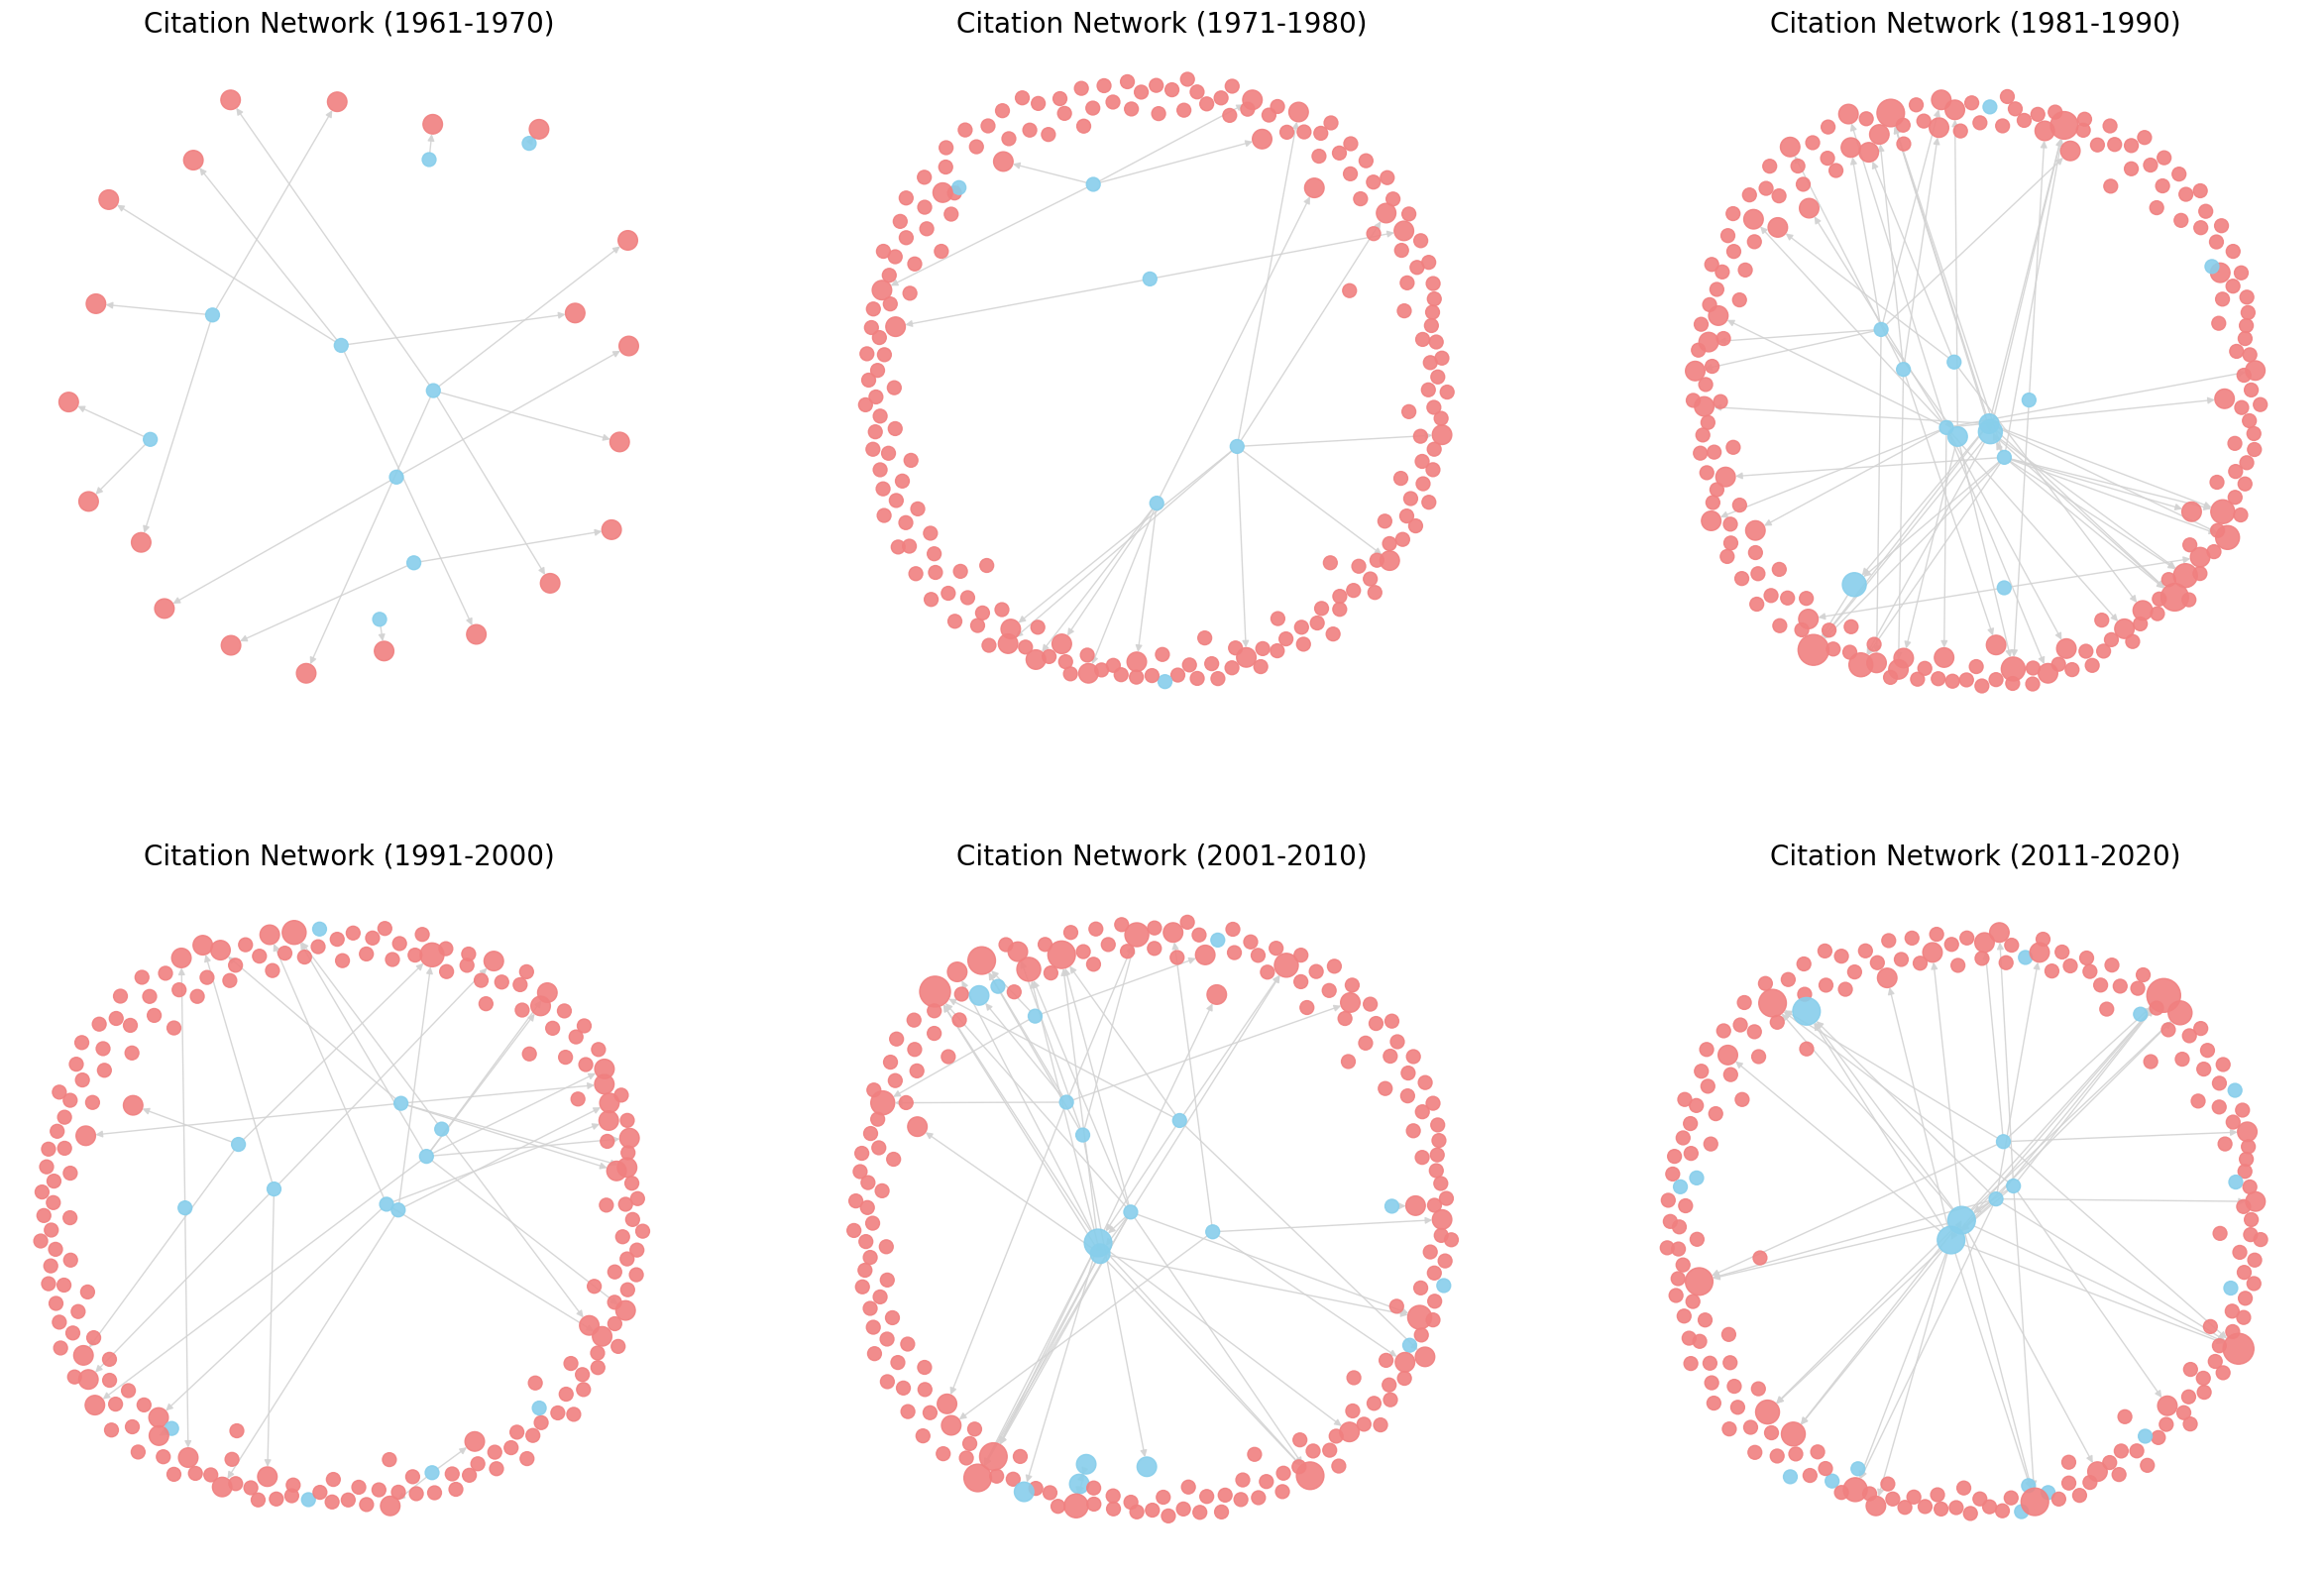

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
axes = axes.flatten()

for i, (label, G) in enumerate(graphs):
    # select the top 200 nodes by in-degree
    G_sub = (
        G.subgraph(sorted(G.nodes, key=G.in_degree, reverse=True)[:200])
        if len(G) > 200
        else G
    )

    pos = nx.spring_layout(G_sub, seed=42, k=0.1)

    # node sizes based on in-degree
    node_sizes = [100 * (G_sub.in_degree(node) + 1) for node in G_sub]

    
    node_colors = ['skyblue' if G_sub.nodes[paper].get("title") != 'null' else 'lightcoral' for paper in G_sub.nodes]

    nx.draw(
        G_sub,
        pos,
        ax=axes[i],
        node_size=node_sizes,
        node_color=node_colors,
        with_labels=False,
        edge_color="lightgray",
        alpha=0.9,
    )
    axes[i].set_title(f"Citation Network ({label})", fontsize=20)

plt.show()

1961-1970: Internal = 0.00%, External = 100.00%
1971-1980: Internal = 2.90%, External = 97.10%
1981-1990: Internal = 3.11%, External = 96.89%
1991-2000: Internal = 3.92%, External = 96.08%
2001-2010: Internal = 3.87%, External = 96.13%
2011-2020: Internal = 4.64%, External = 95.36%


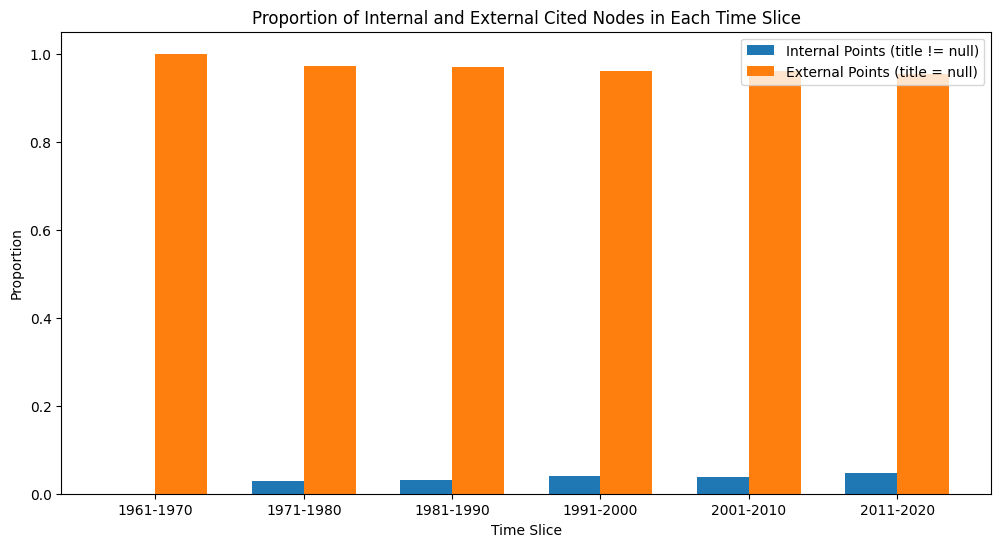

In [18]:
labels = []
internal_ratios = []
external_ratios = []

# Analyze each time slice graph
for label, G in graphs:
    # Select nodes with in-degree > 0 (nodes that are cited)
    cited_nodes = [node for node in G.nodes if G.in_degree(node) > 0]
    # Count internal and external nodes among cited nodes
    internal_count = sum(1 for node in cited_nodes if G.nodes[node].get("title") != 'null')
    external_count = sum(1 for node in cited_nodes if G.nodes[node].get("title") == 'null')
    
    # Calculate total and proportions
    total_count = internal_count + external_count
    internal_ratio = internal_count / total_count if total_count > 0 else 0
    external_ratio = external_count / total_count if total_count > 0 else 0
    
    # Store results for plotting
    labels.append(label)
    internal_ratios.append(internal_ratio)
    external_ratios.append(external_ratio)
    
    # Print the ratios as percentages for reference
    print(f"{label}: Internal = {internal_ratio:.2%}, External = {external_ratio:.2%}")

# Plot bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = range(len(labels))

# Plot internal and external ratios
ax.bar(x, internal_ratios, width=bar_width, label="Internal Points (title != null)")
ax.bar([i + bar_width for i in x], external_ratios, width=bar_width, label="External Points (title = null)")

# Add labels, title, and legend
ax.set_xlabel("Time Slice")
ax.set_ylabel("Proportion")
ax.set_title("Proportion of Internal and External Cited Nodes in Each Time Slice")
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Show plot
plt.show()